In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [4]:
0.8816
'''
res = 128
input_dim = (res,res)
input_size  = res*res   # images are 32x32 pixels
output_size = 8      # there are 10 classes

def load_train_dataset():
    data_path = 'E:/Users/spectR/Desktop/%projects/mlai/tai wai/XY_data/XY_samples/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            transforms.Resize(input_dim),
            transforms.ToTensor()
            ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        num_workers=0,
        shuffle=True
    )
    return train_loader

def load_test_dataset():
    data_path = 'E:/Users/spectR/Desktop/%projects/mlai/tai wai/IsingML/test/'
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            transforms.Resize(input_dim),
            transforms.ToTensor()
            ])
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )
    return test_loader

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                       #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                       #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=100, shuffle=True)
'''

"\nres = 128\ninput_dim = (res,res)\ninput_size  = res*res   # images are 32x32 pixels\noutput_size = 8      # there are 10 classes\n\ndef load_train_dataset():\n    data_path = 'E:/Users/spectR/Desktop/%projects/mlai/tai wai/XY_data/XY_samples/'\n    train_dataset = torchvision.datasets.ImageFolder(\n        root=data_path,\n        transform=torchvision.transforms.Compose([\n            transforms.Resize(input_dim),\n            transforms.ToTensor()\n            ])\n    )\n    train_loader = torch.utils.data.DataLoader(\n        train_dataset,\n        batch_size=1,\n        num_workers=0,\n        shuffle=True\n    )\n    return train_loader\n\ndef load_test_dataset():\n    data_path = 'E:/Users/spectR/Desktop/%projects/mlai/tai wai/IsingML/test/'\n    test_dataset = torchvision.datasets.ImageFolder(\n        root=data_path,\n        transform=torchvision.transforms.Compose([\n            transforms.Resize(input_dim),\n            transforms.ToTensor()\n            ])\n    )\n    t

In [102]:

res = 128
input_dim = (res,res)
input_size  = res*res   # images are 32x32 pixels
output_size = 1      # there are 10 classes

data_path = 'E:/Users/spectR/Desktop/%projects/mlai/tai wai/XY_data/XY_samples/'
dataset_all = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=torchvision.transforms.Compose([
        transforms.CenterCrop(16),
        transforms.Resize((16,16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
)
dataset_size = len(dataset_all)
'''
indices = list(range(dataset_size))
split = int(np.floor(.2 * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
    
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
'''
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_all, [train_size, test_size])

def load_train_dataset():   
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        num_workers=0,
        shuffle = True
    )
    return train_loader
def load_test_dataset():   
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=0,
        shuffle = True
    )
    return test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

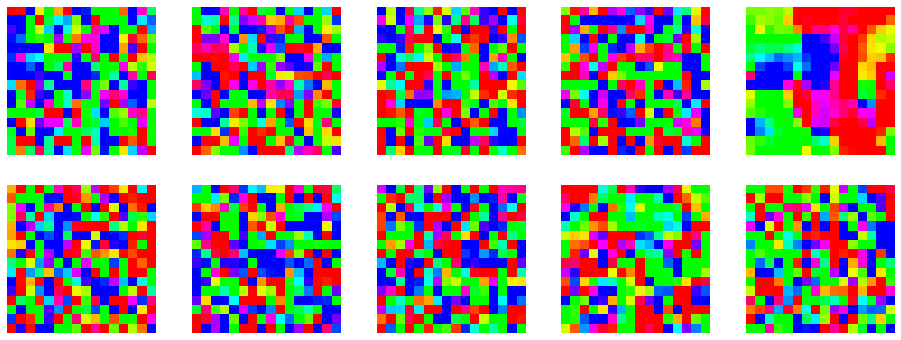

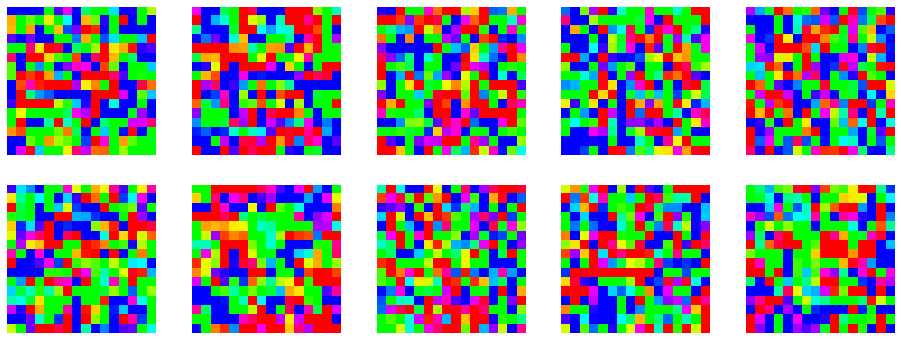

In [103]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = (load_train_dataset()).dataset.__getitem__(i)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off');

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = (load_test_dataset()).dataset.__getitem__(i)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off');


In [104]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=2)
        self.batchnorm = nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*15*15, 1)
        #self.fc2 = nn.Linear(12, 1)
        self.predict = nn.ReLU()
        
    def forward(self, x, verbose=True):
        # F here is the library of functionals
        #x = x.view(-1, self.n_feature*50*50)
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = F.relu(x)
        
        #x = F.max_pool2d(x, kernel_size=2)
        #x = self.conv2(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, kernel_size=2)
        #x = self.conv3(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, kernel_size=2)
        #x = self.conv4(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*15*15)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.2)
        #x = self.fc2(x)
        #x = F.log_softmax(x, dim=1)
        x = self.predict(x)
        return x

In [132]:
accuracy_list = []

def sigmoidLoss(output,target):
    loss = torch.nn.Sigmoid()
    return abs(2*loss(output)-target)

def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(load_train_dataset()):
        # send to device
        data, target = data.to(device), target.to(device)
        #print(data,target)
        target = target.to(torch.float32)
        target = target.view(-1,1)
        optimizer.zero_grad()
        output = model(data)
        #print("output",output)
        loss = sigmoidLoss(output, target)
        #loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(load_train_dataset().dataset),
                100. * batch_idx / len(load_train_dataset()), loss.item()))
      

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in load_test_dataset():
        # send to device
        data, target = data.to(device), target.to(device)
        
        target = target.to(torch.float32)
        target = target.view(-1,1)
        output = model(data) 
        test_loss += sigmoidLoss(output, target).item()
        #test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(load_test_dataset().dataset)
    accuracy = 100. * correct / len(load_test_dataset().dataset)
    accuracy_list.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(load_test_dataset().dataset),
        accuracy))
    
    

In [133]:
# Training settings 
n_features = 16 # number of feature maps
print(input_size, output_size)
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.Adadelta(model_cnn.parameters(), lr=0.00001)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

print(model_cnn)
for epoch in range(0, 5):
    train(epoch, model_cnn)
    test(model_cnn)



16384 1
Number of parameters: 3841
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
  (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3600, out_features=1, bias=True)
  (predict): ReLU()
)
Train Epoch: 0 [0/1591 (0%)]	Loss: 640.967163
Train Epoch: 0 [100/1591 (6%)]	Loss: 501.000000
Train Epoch: 0 [200/1591 (13%)]	Loss: 1072.000000
Train Epoch: 0 [300/1591 (19%)]	Loss: 132.000000
Train Epoch: 0 [400/1591 (25%)]	Loss: 1235.000000
Train Epoch: 0 [500/1591 (31%)]	Loss: 299.749390
Train Epoch: 0 [600/1591 (38%)]	Loss: 741.000000
Train Epoch: 0 [700/1591 (44%)]	Loss: 1006.653564
Train Epoch: 0 [800/1591 (50%)]	Loss: 1508.000000
Train Epoch: 0 [900/1591 (57%)]	Loss: 401.000000
Train Epoch: 0 [1000/1591 (63%)]	Loss: 1254.754883
Train Epoch: 0 [1100/1591 (69%)]	Loss: 597.000000
Train Epoch: 0 [1200/1591 (75%)]	Loss: 974.000000
Train Epoch: 0 [1300/1591 (82%)]	Loss: 165.000000
Train Epoch: 0 [1400/1591 (88%)

In [115]:
categories = ['.001', '.005', '.01', '.05', '.1', '.5', '1', '5']

def show_predictions(rows=10, columns = 10):
    y_pred = []
    y_true = []
    x = []
    maxtoshow = rows * columns
    
    i = 0
    for data, target in load_test_dataset():
        if i>=maxtoshow:
            break
        data, target = data.to(device), target.to(device)
        output = model_cnn(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        x.append(data.view(-1,3,32,32)[0].permute(1, 2, 0).cpu())
        y_pred.append(pred)
        y_true.append(target)
        i = i + 1
        

    ii = 0
    plt.figure(figsize=(32, 32))
    for i in range(len(x)):
        if ii>=maxtoshow:
            break
        plt.subplot(rows, columns, ii+1)
        plt.axis('off')
        plt.imshow(x[i].numpy())
        plt.title("%s (%s)" % (categories[y_pred[i][0]], categories[y_true[i][0]]))
        ii = ii + 1
    plt.tight_layout()

show_predictions()

RuntimeError: shape '[-1, 3, 32, 32]' is invalid for input of size 768